In [1]:
from esda.moran import Moran
import geopandas as gpd
from libpysal.weights import DistanceBand, KNN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from splot.esda import plot_moran
import sys

from statshelper import q_q_plot
plt.style.use('dark_background')

In [2]:
df = pd.read_csv("./data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


In [3]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
X = df[i_vars]
y = df[dep_var]

In [4]:
X_cons = sm.add_constant(X)
ols = sm.OLS(y, X_cons, name_y=dep_var, name_x=i_vars).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale Price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                 4.813e+04
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        11:51:30   Log-Likelihood:            -2.8583e+05
No. Observations:              324261   AIC:                         5.717e+05
Df Residuals:                  324247   BIC:                         5.718e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.854e-09      0.001  -1.81e-06      1.000      -0.002       0.002
Age                     -0.1353      0.001   -104.753      0.000      -0.138      -0.133
Bedrooms                -0.0112      0.002     -5.286      0.000      -0.015      -0.007
Building Square Feet     0.0171      0.002      7.069      0.000       0.012       0.022
Estimate (Building)      0.5058      0.002    308.930      0.000       0.503       0.509
Estimate (Land)          0.3456      0.002    221.721      0.000       0.343       0.349
Fireplaces               0.0134      0.001     10.500      0.000       0.011       0.016
Full Baths              -0.0022      0.002     -1.180      0.238      -0.006       0.001
Garage 1 Area            0.0376      0.001     34.901      0.000       0.035       0.040
Garage 2 Area            0.0004      0.001      0.393      0.694      -0.002       0.002
Half Baths               0.0306      0.001     25.439      0.000       0.028       0.033
Land Square Feet        -0.0674      0.001    -51.921      0.000      -0.070      -0.065
Rooms                    0.0160      0.002      6.613      0.000       0.011       0.021
Sale Quarter             0.1132      0.001    109.835      0.000       0.111       0.115
==============================================================================
Omnibus:                    48986.695   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           261705.492
Skew:                          -0.627   Prob(JB):                         0.00
Kurtosis:                       7.219   Cond. No.                         5.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

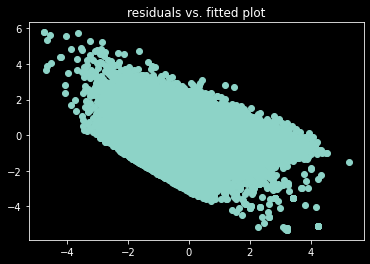

In [5]:
plt.scatter(ols.predict(), ols.resid)
plt.title("residuals vs. fitted plot")
plt.show()

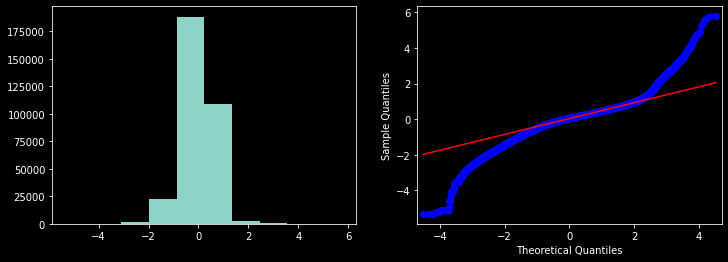

In [6]:
q_q_plot(ols.resid)

In [7]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")

<AxesSubplot:>

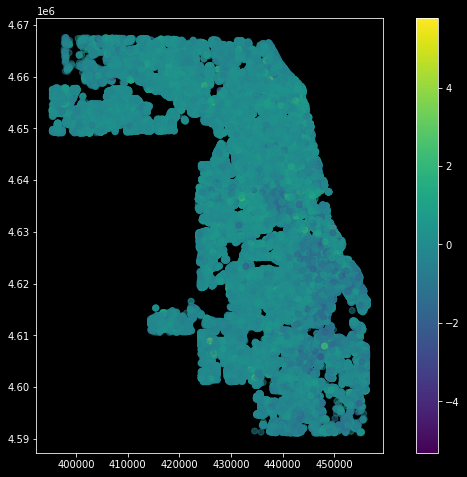

In [8]:
gdf.plot(column=ols.resid, legend=True,
         alpha=0.5, figsize=(12,8))

In [ ]:
#w = DistanceBand.from_dataframe(gdf,threshold=800) # needed k large enough that it was connected
w = KNN.from_dataframe(gdf,k=256)
w.transform = 'R'

In [ ]:
ols_moran = Moran(ols.resid, w, permutations=199)
plot_moran(ols_moran, zstandard=True, figsize=(10,4))
plt.show()